# Statistical analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

d = pd.read_csv("data-processed.csv")
#d = d[-72:] # use just the data for the  last participant

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

## Participants

In [2]:
print("Number of participants:")
print(len(d["Participant ID"].unique()))
print()
print("Native vs. non-native:")
#print(d["Native"].value_counts())
print()
print("Different kinds of designers:")
#print(d["Designer"].value_counts())


Number of participants:
21

Native vs. non-native:

Different kinds of designers:


## JoM for categories of designers

In [3]:
display(d.groupby("Designer")["JoM"].mean())

Designer
Non-designer      45.416667
Other designer    48.333333
Name: JoM, dtype: float64

## JoL for categories of designers (draft)

In [4]:
display(d.groupby("Designer")["JoL"].value_counts())

Designer        JoL                   
Non-designer    easy to read              396
                difficult to read         360
                very easy to read         288
                ok                        144
                very difficult to read    108
Other designer  difficult to read          72
                ok                         72
                easy to read               36
                very easy to read          36
Name: JoL, dtype: int64

## Calculating AUC and RT

In [5]:
fonts = set(d["Font"].unique())

result_columns = ["Study ID", "Participant ID", "Test ID", "Test type",
                  "Native", "Designer", "Font", "Correct", "Response time",
                  "Response time (word)", "Response time (non-word)",
                  "AUC", "AUC (word)", "AUC (non-word)",
                  "JoL", "JoM", "Date"]
agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
agg_columns["Correct"] = "mean"
agg_columns["Response time"] = "mean"
results = d.groupby(["Study ID", "Participant ID", "Test ID", "Test type"]).agg(agg_columns)
results = pd.DataFrame(results, columns=result_columns)
results.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)

# prepare indexes for temporary data frames
ix = {}
test_ids = set(d["Test ID"].unique())
category_used = "Category"
categories = ["word", "non-word"]
responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
category_used = "Seen"
categories = ["seen", "not seen"]
responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

for sid in d["Study ID"].unique():
    for pid in d[d["Study ID"] == sid]["Participant ID"].unique():
        for tid in test_ids:
            dt = d[(d["Study ID"] == sid) & (d["Participant ID"] == pid) & (d["Test ID"] == tid)]
            for ttype in dt["Test type"].unique():
                category_used, index = ix[ttype]
                # ensure the order in the index is always the same
                dg = pd.DataFrame(index=index)
                dg["Frequencies"] = dt[dt["Test type"] == ttype].groupby([category_used])["Response"].value_counts()
                dg = dg.fillna(0)
                # frequencies for word/seen -> y coordinate
                # frequencies for non-word/not seen -> x coordinate
                freqs = dg["Frequencies"].tolist()
                auc = get_auc(freqs[4:], freqs[:4])
                results.loc[(sid, pid, tid, ttype), "AUC"] = auc
                rt = dt[dt["Test type"] == ttype]["Response time"].mean()
                results.loc[(sid, pid, tid, ttype), "Response time"] = rt
                for cat in ["word", "non-word"]:
                    if ttype == "recognition":
                        dg["Frequencies"] = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)].groupby([category_used])["Response"].value_counts()
                        dg = dg.fillna(0)
                        freqs = dg["Frequencies"].tolist()
                        auc = get_auc(freqs[4:], freqs[:4])
                        results.loc[(sid, pid, tid, ttype), "AUC (%s)" % cat] = auc
                    rt = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)]["Response time"].mean()
                    results.loc[(sid, pid, tid, ttype), "Response time (%s)" % cat] = rt
            
display(results[-4:])
results.to_csv("statistical-results.csv")

Native      Designer  \
Study ID Participant ID Test ID Test type                           
0.0      20.0           1       lexical        True  Non-designer   
                                recognition    True  Non-designer   
                        2       lexical        True  Non-designer   
                                recognition    True  Non-designer   

                                                      Font  Correct  \
Study ID Participant ID Test ID Test type                             
0.0      20.0           1       lexical      sansforgetica   1.0000   
                                recognition  sansforgetica   0.9375   
                        2       lexical          inputsans   1.0000   
                                recognition      inputsans   0.8125   

                                             Response time  \
Study ID Participant ID Test ID Test type                    
0.0      20.0           1       lexical           2239.250   
                                recognition       2636.875   
                        2       lexical           1840.450   
                                recognition       2145.875   

                                             Response time (word)  \
Study ID Participant ID Test ID Test type                           
0.0      20.0           1       lexical                  2124.000   
                                recognition              2694.000   
                        2       lexical                  1731.300   
                                recognition              2032.625   

                                             Response time (non-word)  \
Study ID Participant ID Test ID Test type                               
0.0      20.0           1       lexical                      2354.500   
                                recognition                  2579.750   
                        2       lexical                      1949.600   
                                recognition                  2259.125   

                                                  AUC  AUC (word)  \
Study ID Participant ID Test ID Test type                           
0.0      20.0           1       lexical      1.000000         NaN   
                                recognition  0.953125     0.90625   
                        2       lexical      1.000000         NaN   
                                recognition  0.914062     0.96875   

                                             AUC (non-word)  \
Study ID Participant ID Test ID Test type                     
0.0      20.0           1       lexical                 NaN   
                                recognition         1.00000   
                        2       lexical                 NaN   
                                recognition         0.84375   

                                                           JoL  JoM  \
Study ID Participant ID Test ID Test type                             
0.0      20.0           1       lexical      difficult to read   42   
                                recognition  difficult to read   42   
                        2       lexical           easy to read   52   
                                recognition       easy to read   52   

                                                         Date  
Study ID Participant ID Test ID Test type                      
0.0      20.0           1       lexical      28-01-2019 10:59  
                                recognition  28-01-2019 10:59  
                        2       lexical      28-01-2019 10:59  
                                recognition  28-01-2019 10:59

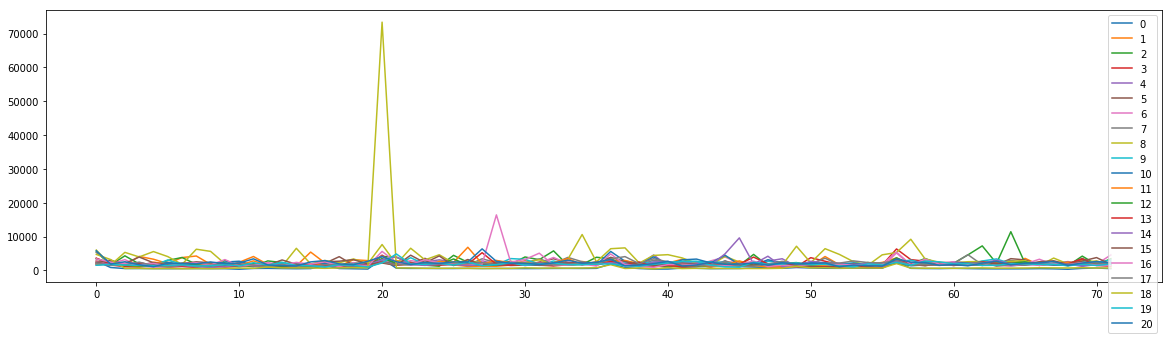

In [222]:
times = pd.DataFrame(d, columns=["Study ID", "Participant ID", "Test ID", "Test type", "Response time"])
times.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)
times = pd.DataFrame(times.values.reshape((-1,72)))
#display(times)
times.T.plot(figsize=(20,5))

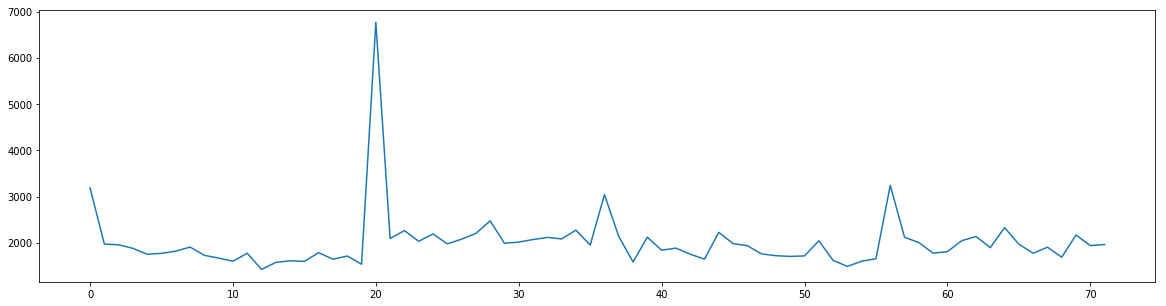

In [223]:
times.mean().plot(figsize=(20,5))